In [1]:
from einshape import jax_einshape as einshape
from jax import lax
import jax
from functools import partial
import sys
sys.path.append('../')
import haiku as hk
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np

from functools import partial
from jax import lax


Here we consider the Poisson equation with Dirichlet boundary conditions: du/dxx = c over domain [0,1], where c is a spatially varying function.

We define the operator $L_{u_0,u_1}: c\rightarrow u$. The operator depends on the boundary conditions $u_0$ and $u_1$.

In [2]:


@partial(jax.jit, static_argnames=('num','kernel'))
def generate_gaussian_process(key, ts, num, kernel, k_sigma, k_l):
  '''
  ts: 1D array (length,)
  out: Gaussian process samples, 2D array (num, length)
  '''
  length = len(ts)
  mean = jnp.zeros((num,length))
  # cov = rbf_kernel(ts[:, None], ts[:, None], sigma=k_sigma, l=k_l)
  cov = kernel(ts, ts, sigma=k_sigma, l=k_l)
  cov = einshape('ii->nii', cov, n = num)
  out = jax.random.multivariate_normal(key, mean=mean, cov=cov, shape=(num,), method='svd')
  return out


def rbf_kernel_jax(x1, x2, sigma, l): # Define the covariance function
    """
    Radial basis function kernel, only support 1D x1 and x2
    """
    xx1, xx2 = jnp.meshgrid(x1, x2, indexing='ij')
    sq_norm = (xx1-xx2)**2/(l**2)
    return sigma**2 * jnp.exp(-0.5 * sq_norm)


def tridiagonal_solve(dl, d, du, b):
  """Pure JAX implementation of `tridiagonal_solve`."""
  prepend_zero = lambda x: jnp.append(jnp.zeros([1], dtype=x.dtype), x[:-1])
  fwd1 = lambda tu_, x: x[1] / (x[0] - x[2] * tu_)
  fwd2 = lambda b_, x: (x[0] - x[3] * b_) / (x[1] - x[3] * x[2])
  bwd1 = lambda x_, x: x[0] - x[1] * x_
  double = lambda f, args: (f(*args), f(*args))

  # Forward pass.
  _, tu_ = lax.scan(lambda tu_, x: double(fwd1, (tu_, x)),
                    du[0] / d[0],
                    (d, du, dl),
                    unroll=32)

  _, b_ = lax.scan(lambda b_, x: double(fwd2, (b_, x)),
                  b[0] / d[0],
                  (b, d, prepend_zero(tu_), dl),
                  unroll=32)

  # Backsubstitution.
  _, x_ = lax.scan(lambda x_, x: double(bwd1, (x_, x)),
                  b_[-1],
                  (b_[::-1], tu_[::-1]),
                  unroll=32)

  return x_[::-1]


@partial(jax.jit, static_argnames=("N"))
def solve_poisson(L, N, u_left, u_right, c): # Poisson equation solver
    '''
    du/dxx = c over domain [0,L]
    c: spatially varying function, size N-1,
    u_left, u_right: boundary conditions.
    the output is the full solution, (N+1) grid point values.
    '''
    dx = L / N
    # x = jnp.linspace(0, L, N+1)

    # finite difference matrix
    du = jnp.array([1.0] * (N-2) + [0.0])
    dl =  jnp.array([0.0] + [1.0] * (N-2))
    d = - 2.0 * jnp.ones((N-1,))

    b = c*dx*dx
    b = b.at[0].add(-u_left)
    b = b.at[-1].add(-u_right)

    out_u = tridiagonal_solve(dl, d, du, b)
    u = jnp.pad(out_u, (1, 1), mode='constant', constant_values=(u_left, u_right))
    return u

solve_poisson_batch = jax.jit(jax.vmap(solve_poisson, in_axes=(None, None, None, None, 0)), static_argnums=(1,))



def generate_pde_poisson(seed, eqns, length, dx, num, file_name):
  '''
  du/dxx = c(x) over domain [0,L]
  c(x) : spatially varying coefficient, size N-1,
          we use GP to sample c(x)
  u_left, u_right: boundary conditions.
  the output is the full solution, (N+1) grid point values.
  '''
  N = length
  L = length * dx
  rng = hk.PRNGSequence(jax.random.PRNGKey(seed))
  coeffs_ul = jax.random.uniform(next(rng), (eqns,), minval = -1.0, maxval = 1.0)
  coeffs_ur = jax.random.uniform(next(rng), (eqns,), minval = -1.0, maxval = 1.0)
  all_xs = []; all_cs = []; all_us = []

  """
  This is a 5D array. [eqns, num, 2, N+1, 2]
  First dimension: number of operators (or equations) 
  Second dimension: number of (u, c) pairs chosen for each operator
  Third dimension: index 0 indicates u; index 1 indicates c
  Fourth dimension: number of positions where x,u,c values are saved for each particular equation
  Fifth dimension: index 0 indicates x; index 1 indicates u or c value at the specified position
  """

  index = -1
  for i, (coeff_ul, coeff_ur) in enumerate(zip(coeffs_ul, coeffs_ur)):
    xs = jnp.linspace(0.0, L, N+1)# (N+1,)
    cs = generate_gaussian_process(next(rng), xs, num, kernel = rbf_kernel_jax, k_sigma = 2.0, k_l = 0.5) # (num, N+1)
    us = solve_poisson_batch(L, N, coeff_ul, coeff_ur, cs[:,1:-1]) # (num, N+1)
    all_xs.append(einshape("i->jik", xs, j = num, k = 1)) # (num, N+1, 1)
    all_cs.append(einshape("ij->ijk", cs, k = 1)) # (num, N+1, 1)
    all_us.append(einshape("ij->ijk", us, k = 1)) # (num, N+1, 1)

  all_xs = np.array(all_xs) # (eqns, num, N+1, 1)
  all_cs = np.array(all_cs) # (eqns, num, N+1, 1)
  all_us = np.array(all_us) # (eqns, num, N+1, 1)

  all_u = np.concatenate([all_xs, all_us], axis = -1) # (eqns, num, N+1, 2)
  all_c = np.concatenate([all_xs, all_cs], axis = -1) # (eqns, num, N+1, 2)
  data = np.concatenate([all_u[:,:,None,:,:], all_c[:,:,None,:,:]], axis = 2) # (eqns, num, 2, N+1, 2)
  file_path = f'./{file_name}.npy'
  np.save(file_path, data)
  print("Data saved successfully")


In [3]:
# Finally we generate data

seed = 1
eqns = 20
xs = 100
dx = 0.01
num_ucpair = 6
file_name = "Poisson_PDE_data"
generate_pde_poisson(seed, eqns, xs, dx, num_ucpair, file_name)

2024-04-21 02:03:47.787790: W external/xla/xla/service/gpu/nvptx_compiler.cc:744] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Data saved successfully


In [4]:
data = np.load(f'./{file_name}.npy')
print(data.shape)

(20, 6, 2, 101, 2)


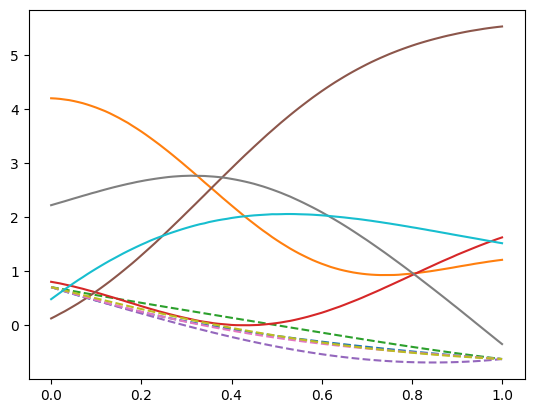

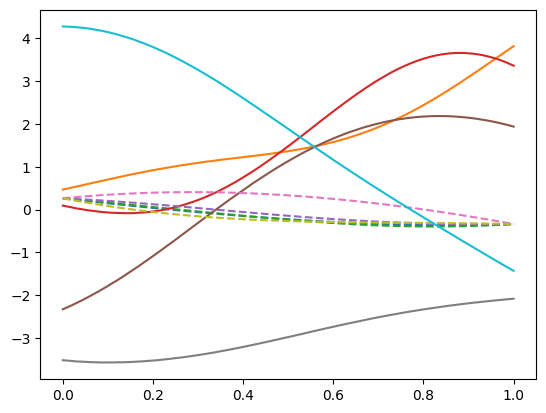

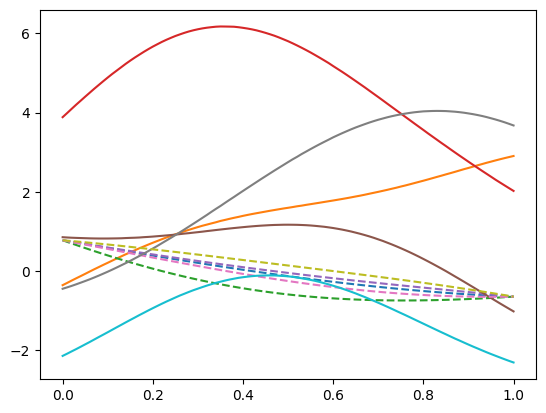

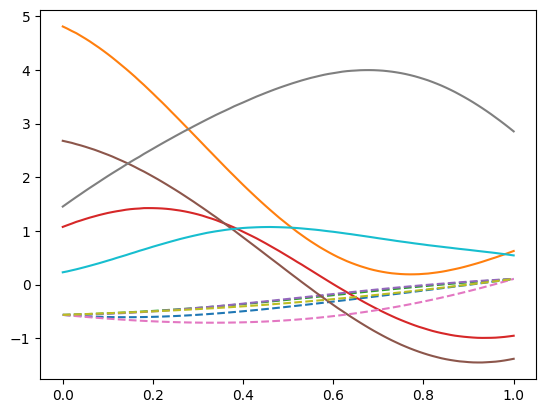

In [5]:
for i in range(4):
  plt.figure()
  for j in range(5):
    plt.plot(data[i,j,0,:,0], data[i,j,0,:,1], label = "u", linestyle = "--")
    plt.plot(data[i,j,1,:,0], data[i,j,1,:,1], label = "c", linestyle = "-")
  plt.show()
